# Data science self learning
## Twitter analysis
### Try the following
- Select food related tweets from 2 million tweets with only one word "Dosa"
- Can we visualize words/ tweet


Importing required modules

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import nltk
import gensim
from gensim.models import word2vec
import sys
import joblib
import gc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize
W2V_LOAD_FROM_FILE =True
WORD_ARRAY_LOAD_FROM_FILE =True
VERBOSE = 10
from IPython.display import IFrame, HTML, Image

In [ ]:
%matplotlib inline
sns.set()
# plt.rcParams['figure.figsize'] = (12,8)

In [ ]:
# custom log function for debugging
def log(msg, level = 0):
    if VERBOSE>0:
        print(msg)
        # print('\a')

## Preparing the data, preprocessing/ loading the saved models

In [ ]:

if WORD_ARRAY_LOAD_FROM_FILE:
    log("Loading the already tokenized words from file")
    with open('words.pkl','rb')as f:words = pickle.load(f)
else:
    log("Opening the raw tet file")
    with open('data/texts/final/en_US/en_US.twitter.txt', 'r') as f:
        txt = f.read()
    sen = nltk.sent_tokenize(txt)
    words = [nltk.word_tokenize(x) for x in sen]
    log("saving the tokenized words")
    with open('words.pkl','wb')as f:pickle.dump(words,f)


if W2V_LOAD_FROM_FILE:
    log("Loading the already trained w2v model from file")
    with open('wv_model.pkl','rb') as f: wv_model = pickle.load(f)
else:
    log("Creating the w2v model from tokens")
    wv_model = word2vec.Word2Vec(words,min_count=1)
    if True:
        log("Saving the trained w2v model to file")
        with open('wv_model.pkl', 'wb') as f:
            pickle.dump(wv_model,f)


In [ ]:
log("creating a data frame")
df = pd.DataFrame({'words':words})

In [104]:
log("Some visualization")
sns.distplot(df_sample.loc[df_sample['wordlen']<100]['wordlen'], rug  =True)
np.max(df['wordlen'])

Some visualization


KeyError: 'wordlen'

In [90]:
def do_stuff_1(df):
    log("calculating the word length per row")
    df['wordlen'] = [len(x) for x in df['words']]
    log("calculating the bag of words vector total for each row")
    wt=[]
    for row in df['words']:
        wt.append(np.sum([wv_model.wv[word] for word in row],axis = 0))
    try:
        df['wv_total']  =wt
        df = df.reset_index()
    except:
        raise
    return df
log("Taking a sample of 100000 rows for the time being")
df_sample = df.sample(1000000)
df_sample = do_stuff_1(df_sample)


Taking a sample of 100000 rows for the time being
calculating the word length per row
calculating the bag of words vector total for each row


##  Trying to visualise the total word vector (bag of words) per tweet

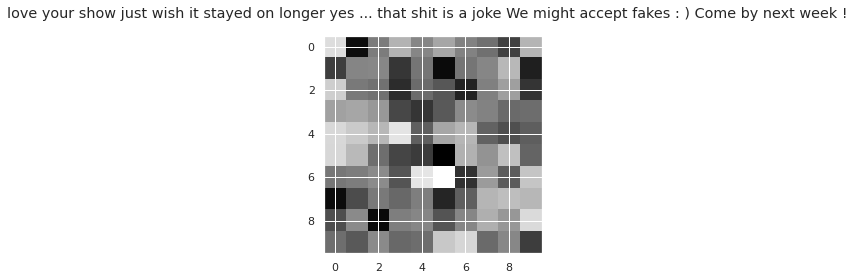

In [91]:
def temp(n):
    x = df_sample['wv_total'][n]
    x = np.repeat(x,3)
    x = (x - np.min(x)) /( np.max(x)-np.min(x) )
    x = np.reshape(x,(10,10,3))
    return [x,' '.join(df_sample['words'][n])]

# fig, axs = plt.subplots(4,4)
k=0
for i in range(0,4):
    for j in range (0,4):
        res = temp(k)
        # axs[i,j].imshow(res[0])
        plt.imshow(res[0])
        plt.suptitle(res[1])
                # print()
        # axs[i,j].set_axis_off()
        k+=1
        


## Trying clustering
### (Did not work. Too diverse)


In [ ]:
# km = KMeans(n_clusters = 50, verbose =None, max_iter = 4000)
# x = np.array(df_sample['wv_total'])
# x = np.array([np.array(x) for x in x])
# clust = km.fit_predict(x)
# df_sample['clust']= clust
# df_sample.loc[df_sample['clust']==20]  

### Trying to classify few tweets manually and then let the model take over


## Searching for the word 'football' hoping to find tweets relating to football
### findings:
    - Data is highly imbalanced.  there are only about 119 tweets witht the word 'football' out of 100,000 tweets

In [95]:
# %%time
searchitems = ['dosa']
i = [ (lambda wrds: any([wrd in searchitems for wrd in wrds]))(lin) for lin in df_sample['words']]
df_sample['football'] = 0
df_sample.loc[np.array(i),'football']=1
df_sample.loc[df_sample['football']==1]

,index,words,wordlen,wv_total,football
290851,1436915,"[dosa, mans, ``, vegan, drumsticks, '', are, I...",9,"[-0.35033, -4.3675528, -5.2937465, 1.786101, -...",1
512037,2402021,"[Ughh, at, least, its, a, way, to, give, away,...",65,"[75.14176, -79.63913, -9.1118355, 50.869694, -...",1
669059,625933,"[1st, visit, 2, an, Indian, grocery, store, &,...",16,"[9.234588, -23.814045, -8.578273, 17.302423, -...",1
803260,2465649,"[If, you, 're, watching, the, Blazers, game, t...",67,"[64.36417, -89.274185, -22.509005, 63.23993, 8...",1


In [96]:
temp1 = df_sample.loc[df_sample['football']==1]
temp2 = df_sample.loc[df_sample['football']==0].sample(300)
df_train = temp1.append(temp2)

In [97]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten
model = Sequential()
model.add(Dense(500,activation='relu', input_shape=(100,)))
model.add(Dropout(.4))
model.add(Dense(300, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [98]:
train_x = df_train.loc[:,'wv_total']
train_x = np.array([np.array(x) for x in df_train.loc[:,'wv_total']])
train_x.shape
train_y = keras.utils.to_categorical(df_train.loc[:,'football'])
train_y.shape
h = model.fit(train_x, train_y, epochs=100,  validation_split = .2, verbose = 0)

# model.fit?

In [99]:
h.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [100]:
df_test = do_stuff_1( df.sample(100000))
df_test

test_x = np.array([np.array(x) for x in df_test.loc[:,'wv_total']])
test_x.shape

pred = model.predict(test_x)
pred = np.round(pred)

df_test['pred_football'] = np.argmax(pred,1)

# df_sample['words'][10]

calculating the word length per row
calculating the bag of words vector total for each row


In [101]:
temp = df_test.loc[df_test['pred_football']==1,'words']
temp = [' '.join(x).strip() for x in temp]
css = '<style>.left_aligned_df td { text-align: left; }</style>'
HTML(css + pd.DataFrame({'tweet':temp[100:200]}).to_html(classes='left_aligned_df'))


,tweet
0,"Awesome vendors , swag bags , raffles , food trucks !"
1,i pick up a fresh bottle 2morrow Im drank out Yeah I do love brunch !
2,"Omelet for breakfast , veggie burger for lunch , and salad for dinner , most likely ."
3,"I am out of soap , tooth paste and shaving cream ."
4,") , olive oil and Serrano ham ?"
5,"Fredo gets whacked at end of Godfather II. ” spoiler I am drinking and didnt Think ... Did Dining Out For Life for lunch , then went to Trader Joe 's , then bought books , then watched Bollywood videos and Band Baaja Baaraat ."
6,I did enjoy your food today !
7,Turns out it was another sushi food truck that offers sushi burritos RT : Kudos to Hillary Clinton for Africa trip to highlight AGOA .
8,# um I 'm telling mom ... Steak quesadillas with cotija & colby jack and peche lambic ale .
9,"( James Thurber ) we have beef on weck , sahlens hot dogs *best* , wings , chevatas chicken etc hope u got too eat good food.. talk tonight - # Seattle Arts & Lectures !"


In [102]:
from ipywidgets import interact
@interact
def dostuff(inp = "hello", x=[1,2,3]):
    return (inp + ' ')*x
# 

'hello '